In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
import statistics
from get_bounds import *
from k_means_equal_size import *

### Grid Points Load (output from scoring.ipynb)
#### Grid Points are now scored in `scoring.ipynb`.

In [3]:
YYZ_GridPoints = pd.read_csv('../res/grid_points/yyz_grid_points_1.csv', sep = ',')

### Parameters

In [4]:
STD_DEV = 0.6
PT_DENSITY = 50

### Regression

In [5]:
def linearRegression(scores):
    # step 1: don't use points that are very small (threshold)
    threshold = statistics.median(scores['score'])
    thresholded_scores = scores.loc[scores['score'] >= threshold]
    #print(thresholded_scores)
    
    regr = LinearRegression()
    lats = thresholded_scores["lat"].values.reshape(-1, 1)
    longs = thresholded_scores["long"].values.reshape(-1, 1)
    regr.fit(lats, longs, thresholded_scores["score"]) # Score is Squared because sample_weight is square rooted thresholded_scores["score"]
    x_begin = lats[0]
    x_end = lats[-1]
    y_begin = regr.predict(x_begin.reshape(1, -1)).item()
    y_end = regr.predict(x_end.reshape(1, -1)).item()
    
    return (x_begin.item(), x_end.item(), y_begin, y_end)

In [6]:
def polynomialRegression(scores, degree, upperLatBound, bottomLatBound):
    poly = PolynomialFeatures(degree, include_bias=False)
    poly_features = poly.fit_transform(scores["lat"].values.reshape(-1, 1))
    poly_reg_model = LinearRegression().fit(poly_features, scores["long"], scores["score"])
    #x = scores['lat'].unique()
    x = np.arange(bottomLatBound, upperLatBound, round((upperLatBound-bottomLatBound)/PT_DENSITY, 4))
    y = poly_reg_model.predict(poly.fit_transform(x.reshape(-1, 1)))
    return (x, y, poly_reg_model.intercept_, poly_reg_model.coef_)

### Filtering and Processing

In [7]:
def trimOutOfBounds(points, upperLatBound, bottomLatBound, leftLongBound, rightLongBound):
    df = pd.DataFrame({'lat': points[0], 'long': points[1]})
    df = df.loc[(df['lat'] >= bottomLatBound) & (df['lat'] <= upperLatBound) & (df['long'] >= leftLongBound) & (df['long'] <= rightLongBound)]
    return (df['lat'].values, df['long'].values)

In [8]:
def snapLongToGrid(points, leftLongBound, rightLongBound):
    step = round((rightLongBound-leftLongBound)/PT_DENSITY, 4)
    pointsDf = pd.DataFrame({'lat': points[0], 'long': points[1]})
    for index, row in pointsDf.iterrows():
        pointsDf.at[index, 'long'] = pointsDf.at[index, 'long'] - ((pointsDf.at[index, 'long'] - leftLongBound) % step)
    return (pointsDf['lat'].values, pointsDf['long'].values)

### Plotting Functions

In [9]:
def plotScores(scores):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    fig.set_figheight(10)
    fig.set_figwidth(10)
    ax.scatter(scores["lat"], scores["long"], scores["score"])
    return ax

In [10]:
def plotScoresWithLine(scores, line):
    ax = plotScores(scores)
    ax.plot([line[0], line[1]], [line[2], line[3]], [0, 0], color='red', linewidth=3)
    return ax

In [11]:
def plotScoresWithCurve(scores, curve):
    ax = plotScores(scores)
    ax.scatter(curve[0], curve[1], 0)
    return ax

In [12]:
def plotHeatmap(scores, line):
    y_begin = line[2]
    y_end = line[3]
    fig = plt.figure()
    ax = sns.heatmap(scores.pivot("long", "lat", "score"))
    y_begin_hm = int((y_begin - scores["long"].iloc[0]) / (scores["long"].iloc[-1] - scores["long"].iloc[0]) * PT_DENSITY)
    y_end_hm = int((y_end - scores["long"].iloc[0]) / (scores["long"].iloc[-1] - scores["long"].iloc[0]) * PT_DENSITY)
    ax.plot([0, PT_DENSITY], [y_begin_hm, y_end_hm], linewidth=3, color='r')
    return ax

In [13]:
def plotHeatmapPolynomial(scores, curves):
    fig = plt.figure()
    ax = sns.heatmap(scores.pivot("long", "lat", "score"))
    for curve in curves:
        x = curve[0]
        y = curve[1]
        x_hm = [int(a) for a in ((x - scores["lat"].iloc[0]) / (scores["lat"].iloc[-1] - scores["lat"].iloc[0]) * PT_DENSITY)]
        y_hm = [int(a) for a in ((y - scores["long"].iloc[0]) / (scores["long"].iloc[-1] - scores["long"].iloc[0]) * PT_DENSITY)]
        ax.scatter(x_hm, y_hm, linewidth=1)
    return ax

### Toronto (YYZ)

In [14]:
[YYZ_UpperLatBound, YYZ_BottomLatBound, YYZ_LeftLongBound, YYZ_RightLongBound] = getBounds(YYZ_GridPoints['lat'], YYZ_GridPoints['long'], 4)

In [15]:
[*YYZ_Line_1, YYZ_Line_1_intercept, YYZ_Line_1_coefficients] = polynomialRegression(YYZ_GridPoints, 3, YYZ_UpperLatBound, YYZ_BottomLatBound)
YYZ_Line_1 = trimOutOfBounds(YYZ_Line_1, YYZ_UpperLatBound, YYZ_BottomLatBound, YYZ_LeftLongBound, YYZ_RightLongBound)
YYZ_Line_1 = snapLongToGrid(YYZ_Line_1, YYZ_LeftLongBound, YYZ_RightLongBound)

<Axes3DSubplot:>

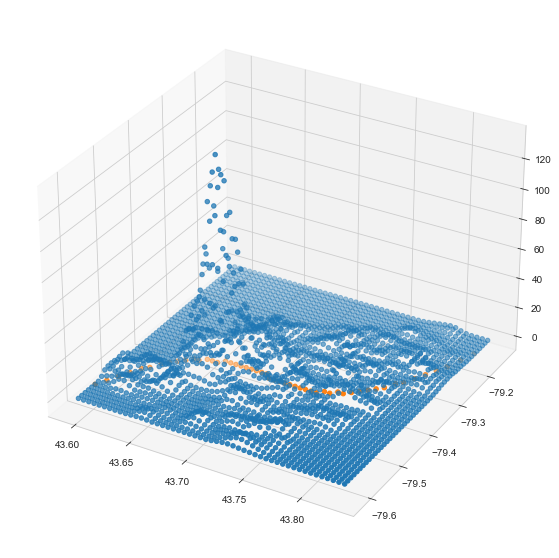

In [16]:
plotScoresWithCurve(YYZ_GridPoints, YYZ_Line_1)

<AxesSubplot:xlabel='lat', ylabel='long'>

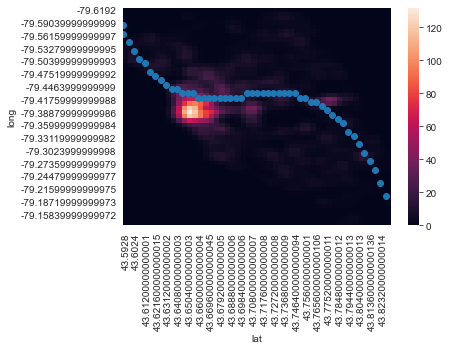

In [17]:
plotHeatmapPolynomial(YYZ_GridPoints, [YYZ_Line_1])

### Clustering Test

In [18]:
NUM_CLUSTERS = 6

In [19]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
YYZ_C_Scores = YYZ_GridPoints.copy()
YYZ_C_Scores = YYZ_C_Scores.loc[YYZ_C_Scores['score'] > 0.5]

In [67]:
#for index, row in YYZ_C_Scores.iterrows():
#    YYZ_C_Scores.at[index, 'score'] = (YYZ_C_Scores.at[index, 'score']*2)**2

In [68]:
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=0).fit(YYZ_C_Scores[["lat", "long"]], 0, YYZ_C_Scores["score"])

In [69]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(YYZ_C_Scores[["lat", "long"]])
    distortions.append(kmeanModel.inertia_)

C:\Users\trieu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


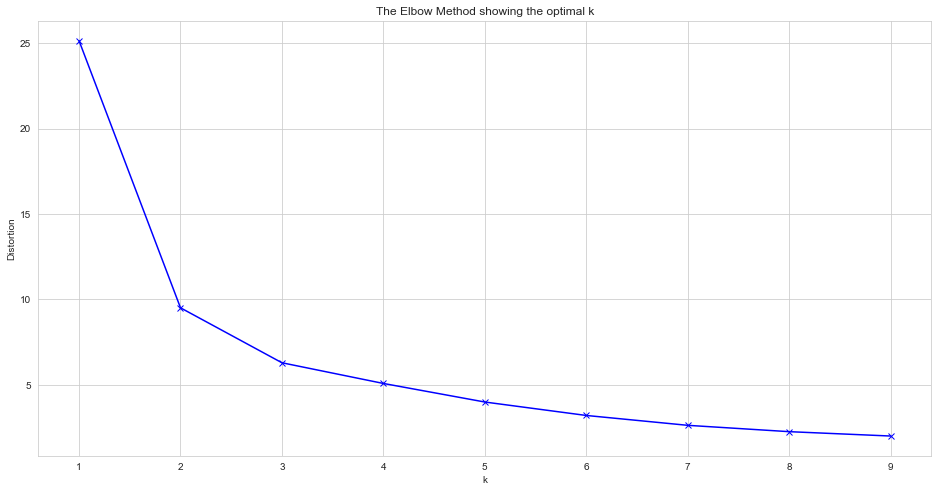

In [70]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

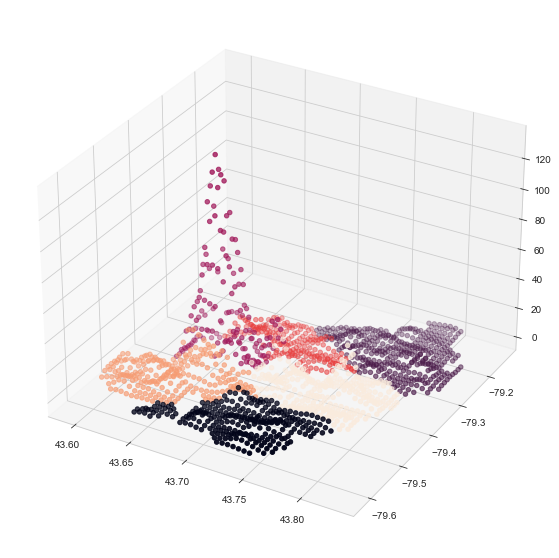

In [71]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
fig.set_figheight(10)
fig.set_figwidth(10)
ax.scatter(YYZ_C_Scores["lat"], YYZ_C_Scores["long"], YYZ_C_Scores["score"], c=kmeans.labels_.astype(float))

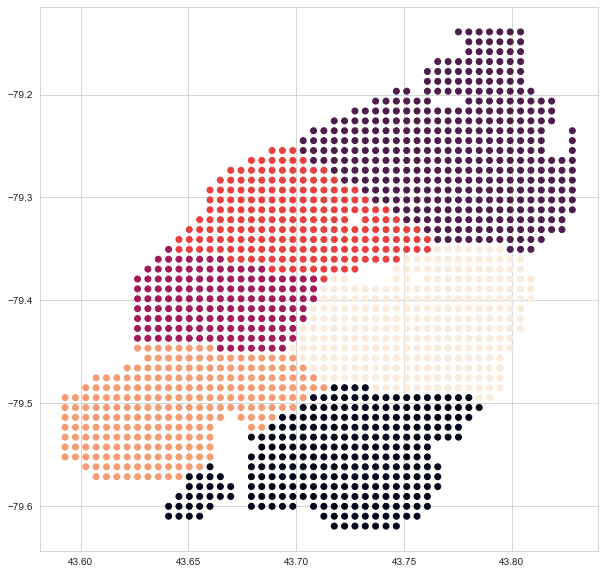

In [72]:
fig = plt.figure()
ax = fig.add_subplot()
fig.set_figheight(10)
fig.set_figwidth(10)
ax.scatter(YYZ_C_Scores["lat"], YYZ_C_Scores["long"], c=kmeans.labels_.astype(float))

In [73]:
YYZ_C_Scores['cluster'] = kmeans.labels_.tolist()

In [74]:
def getLine(scores, upper, bottom, left, right):
    [*line, line_intercept, line_coefficients] = polynomialRegression(scores, 5, upper, bottom)
    line = trimOutOfBounds(line, upper, bottom, left, right)
    line = snapLongToGrid(line, left, right)
    return (line, line_intercept, line_coefficients)

In [75]:
YYZ_Cx_Scores = []
for i in range(NUM_CLUSTERS):
    YYZ_Cx_Scores.append(YYZ_C_Scores.loc[YYZ_C_Scores['cluster'] == i])

In [76]:
YYZ_Cx_Line = []
for i in range(NUM_CLUSTERS):
    [line, _, _] = getLine(YYZ_Cx_Scores[i], YYZ_UpperLatBound, YYZ_BottomLatBound, YYZ_LeftLongBound, YYZ_RightLongBound)
    YYZ_Cx_Line.append(line)

<AxesSubplot:xlabel='lat', ylabel='long'>

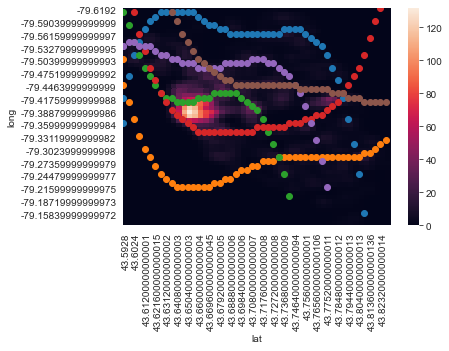

In [77]:
plotHeatmapPolynomial(YYZ_GridPoints, YYZ_Cx_Line)

In [78]:
YYZ_Cx_Line

[(array([43.5928, 43.5975, 43.6022, 43.6069, 43.6116, 43.6163, 43.621 ,
         43.6257, 43.6304, 43.6351, 43.6398, 43.6445, 43.6492, 43.6539,
         43.6586, 43.6633, 43.668 , 43.6727, 43.6774, 43.6821, 43.6868,
         43.6915, 43.6962, 43.7009, 43.7056, 43.7103, 43.715 , 43.7197,
         43.7244, 43.7291, 43.7338, 43.7385, 43.7432, 43.7479, 43.7526,
         43.7573, 43.762 , 43.7667, 43.7714, 43.7761, 43.7808, 43.7855,
         43.7902, 43.7949, 43.7996, 43.8043, 43.809 ]),
  array([-79.3504, -79.408 , -79.456 , -79.504 , -79.5328, -79.5616,
         -79.5808, -79.5904, -79.6   , -79.6096, -79.6096, -79.6096,
         -79.6096, -79.6   , -79.6   , -79.5904, -79.5808, -79.5712,
         -79.5712, -79.5616, -79.5616, -79.552 , -79.552 , -79.552 ,
         -79.552 , -79.552 , -79.552 , -79.552 , -79.552 , -79.552 ,
         -79.552 , -79.5616, -79.5616, -79.5616, -79.5616, -79.552 ,
         -79.5424, -79.5328, -79.5232, -79.504 , -79.4752, -79.4464,
         -79.408 , -79.36  , 

### Export Cells

In [79]:
with open('coords.txt', 'w') as f:
    f.write("----------LATS-------\n")
    for line in YYZ_Cx_Line:
        f.write("[")
        for lat in line[0]:
            f.write(str(lat))
            f.write(',')
        f.write("],")
        f.write("\n")
    f.write("----------LONGS-------\n")
    for line in YYZ_Cx_Line:
        f.write("[")
        for long in line[1]:
            f.write(str(long))
            f.write(',')
        f.write("],")
        f.write("\n")

### Toronto Test (Preliminary Work for Interchanges)